Showing Stan samples correctly for the simple "bunch of normals being led around" problem.

In [1]:
# set up Python
import json
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2
from cmdstanpy import CmdStanModel
import plotnine
from plotnine import *

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
N = 1000

In [3]:
data_file_name = "stan_test_data.json"
src_file_name = "stan_test_src.stan"

In [4]:
stan_src = """
data {
  int<lower=1> N;
}
parameters {
  real c;
  vector[N] x;
}
model {
  c ~ normal(0, 1);
  x ~ normal(c, 1);
}
"""

In [5]:

data_str = f"""
{{
  "N": {N}
}}
"""

In [6]:

with open(data_file_name, "w", encoding="utf8") as file:
    file.write(data_str)
with open(src_file_name, "w", encoding="utf8") as file:
    file.write(stan_src)
# instantiate the model object
model = CmdStanModel(stan_file=src_file_name)
# fit the model and draw observations
# https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample
# https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.optimize
fit = model.sample(
    data=data_file_name,
    show_progress=False,
    show_console=False,
)
# get the samples
res = fit.draws_pd()

In [7]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,c,x[1],x[2],...,x[991],x[992],x[993],x[994],x[995],x[996],x[997],x[998],x[999],x[1000]
0,-491.560,0.995387,0.089037,6.0,63.0,0.0,1023.650,0.714343,0.761098,1.048790,...,0.891360,1.126840,0.369699,-0.157882,0.635045,1.386160,0.062228,1.022890,1.386270,-0.052809
1,-520.008,0.891125,0.089037,6.0,63.0,0.0,1000.390,0.695439,1.666240,0.249446,...,0.746307,1.164260,-0.636105,-0.478596,1.018590,1.981860,0.155619,1.355990,1.582220,1.822640
2,-509.336,0.973063,0.089037,6.0,63.0,0.0,1034.470,0.662750,0.898193,-0.367390,...,0.566706,1.019570,0.619587,2.163870,0.224527,-0.577407,1.657910,-0.404927,1.903550,0.360266
3,-512.555,0.988171,0.089037,6.0,63.0,0.0,993.013,0.643190,0.397579,1.618460,...,0.856452,0.669785,0.950691,-0.712861,1.110470,1.965300,-0.058047,1.850900,-0.395078,1.028790
4,-493.996,0.976613,0.089037,6.0,63.0,0.0,1013.780,0.601225,0.877926,0.230856,...,0.609924,0.640320,-0.053105,1.874640,-0.851222,-0.925880,0.467172,-1.042270,0.853464,0.670791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-554.694,0.828778,0.063577,6.0,63.0,0.0,1034.100,-0.210827,-0.905828,-1.077340,...,-0.534099,-0.311718,-0.078767,0.144553,0.371659,-1.057480,-0.149355,-0.260792,0.632215,-1.143260
3996,-501.946,0.973558,0.063577,6.0,63.0,0.0,1055.390,-0.213063,0.502048,0.372192,...,0.783145,-1.217840,-0.870339,-1.473630,-0.520287,1.507500,0.541025,-0.793112,-1.348520,0.164442
3997,-498.475,0.978139,0.063577,6.0,63.0,0.0,1028.900,-0.236938,-1.037360,-0.801112,...,-0.752790,0.638671,-0.419462,0.902898,-0.386276,-1.377480,-0.659608,0.451675,0.713549,-0.601059
3998,-502.367,0.995183,0.063577,6.0,63.0,0.0,1047.370,-0.214713,1.189820,0.235050,...,0.632005,-0.814475,0.729424,-0.574733,0.864989,0.538636,0.442014,-0.505332,-0.753666,-0.649060


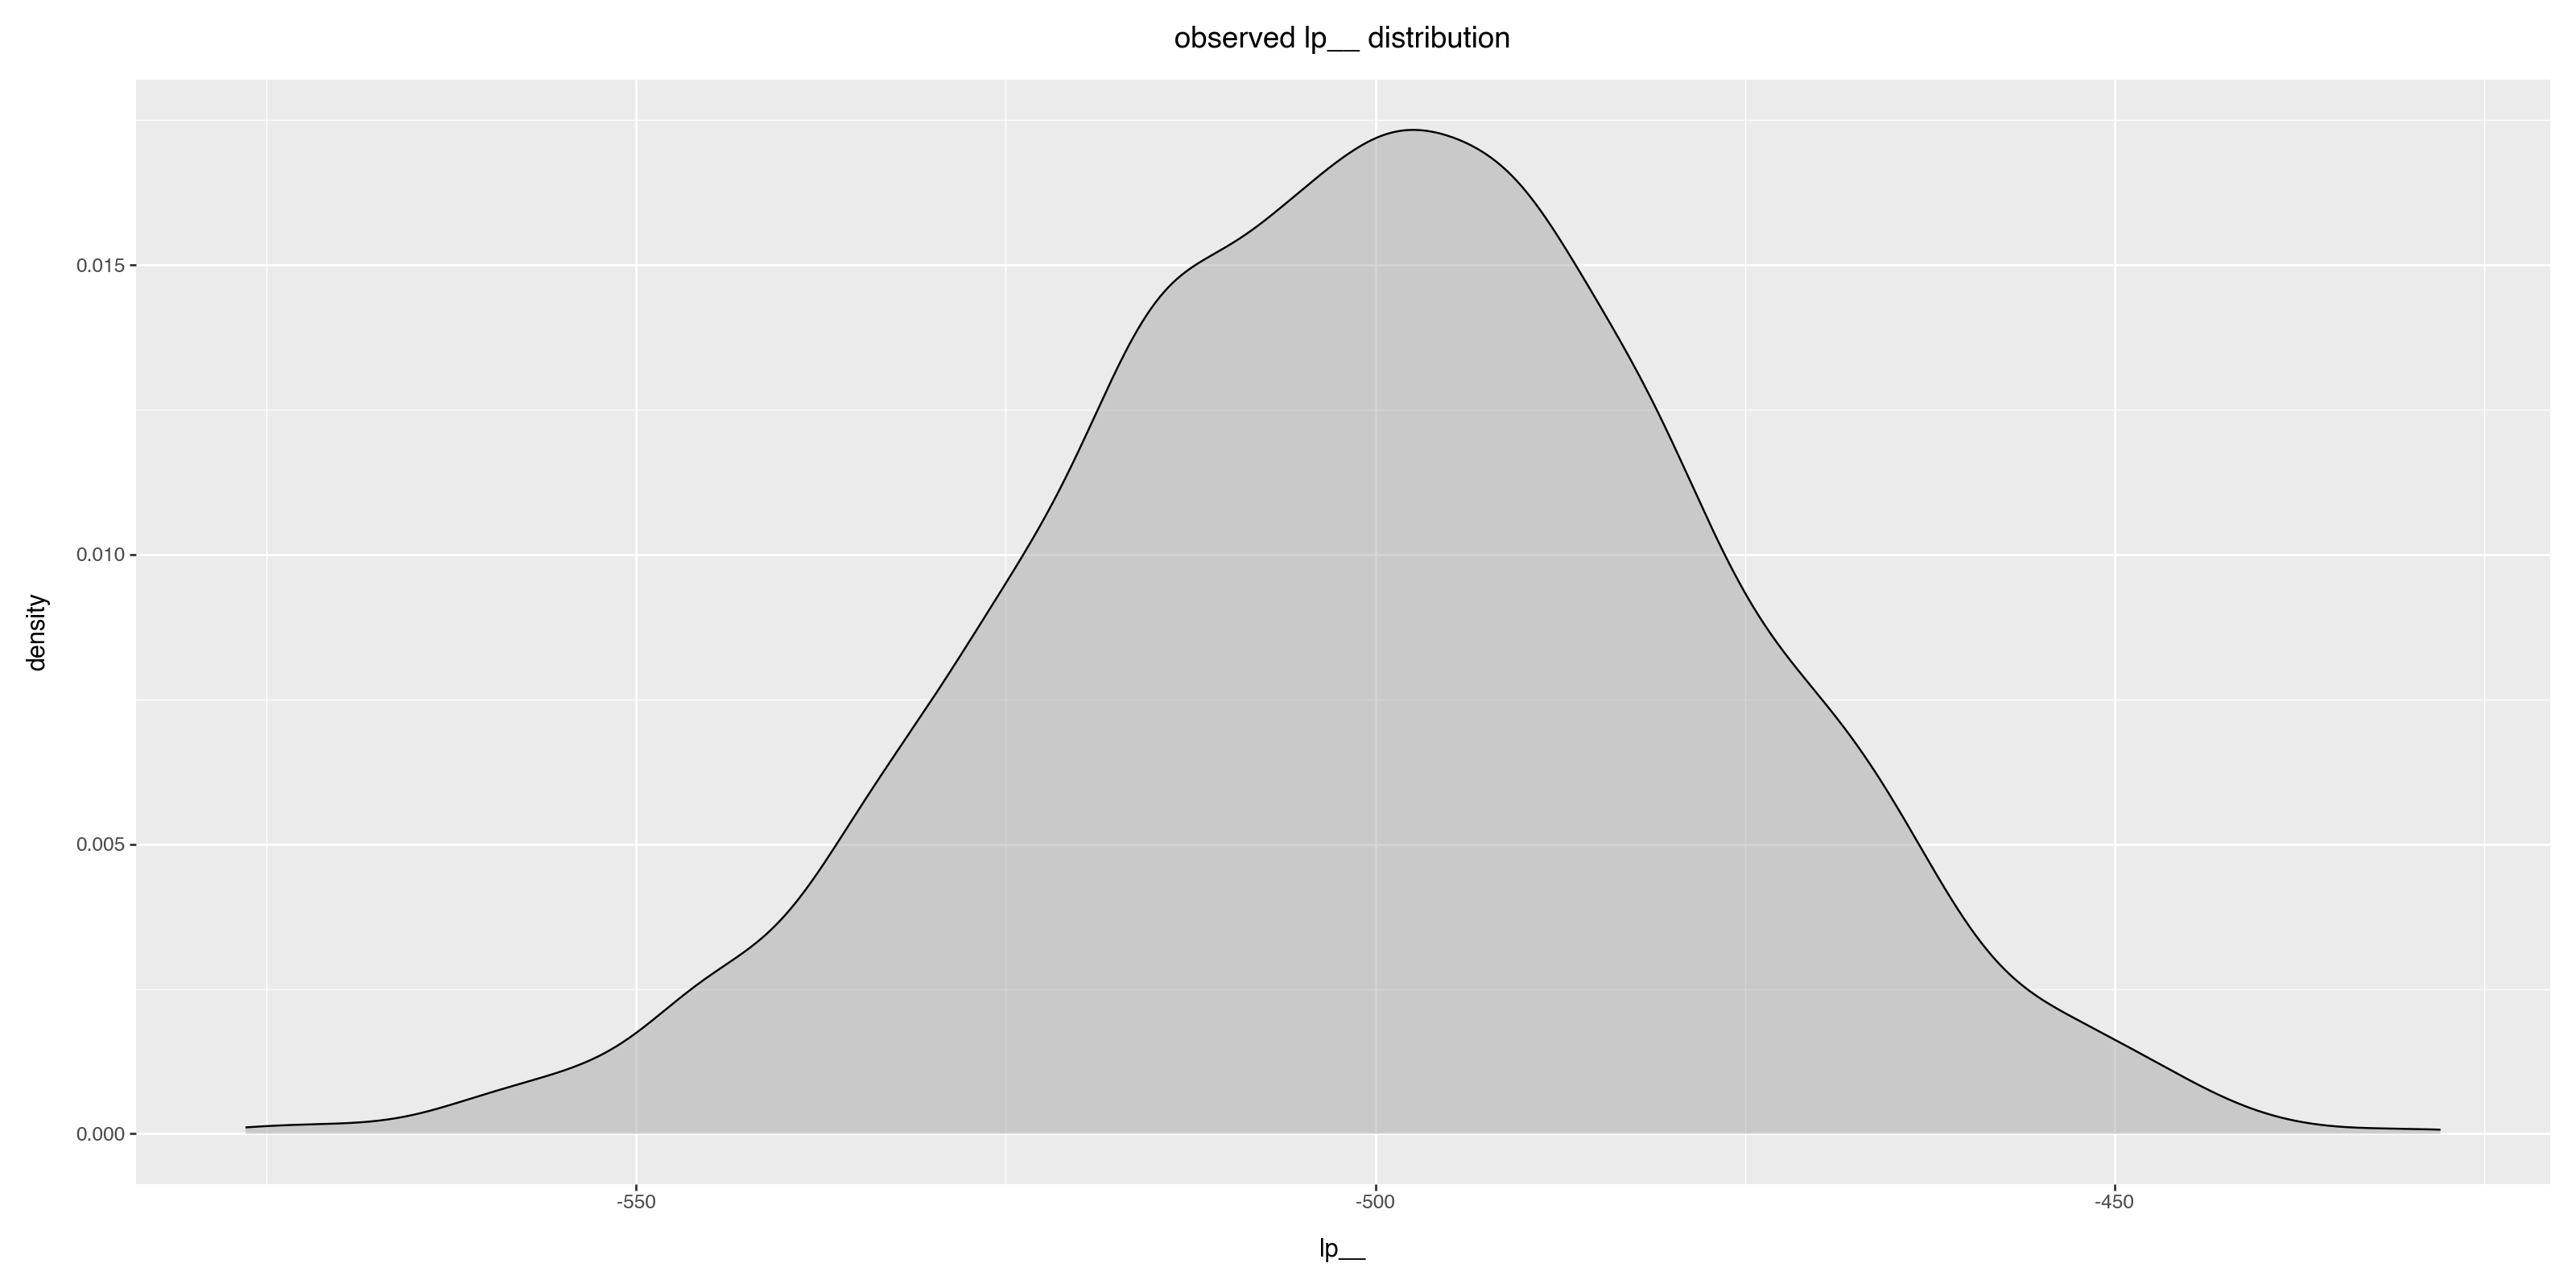

In [8]:
(
    ggplot(
        data=res,
        mapping=aes(x='lp__')
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle("observed lp__ distribution")
)

In [9]:
c = res['c']
log_density = -(c**2)/2 - np.log(2 * np.pi)/2
sum_sq = np.zeros(res.shape[0], dtype=float)
for i in range(1, N+1):
    x = res[f'x[{i}]']
    log_density += -((x - c)**2)/2 - np.log(2 * np.pi)/2 
    sum_sq += (x - c)**2
res['log_density'] = log_density
res['sum_sq'] = sum_sq

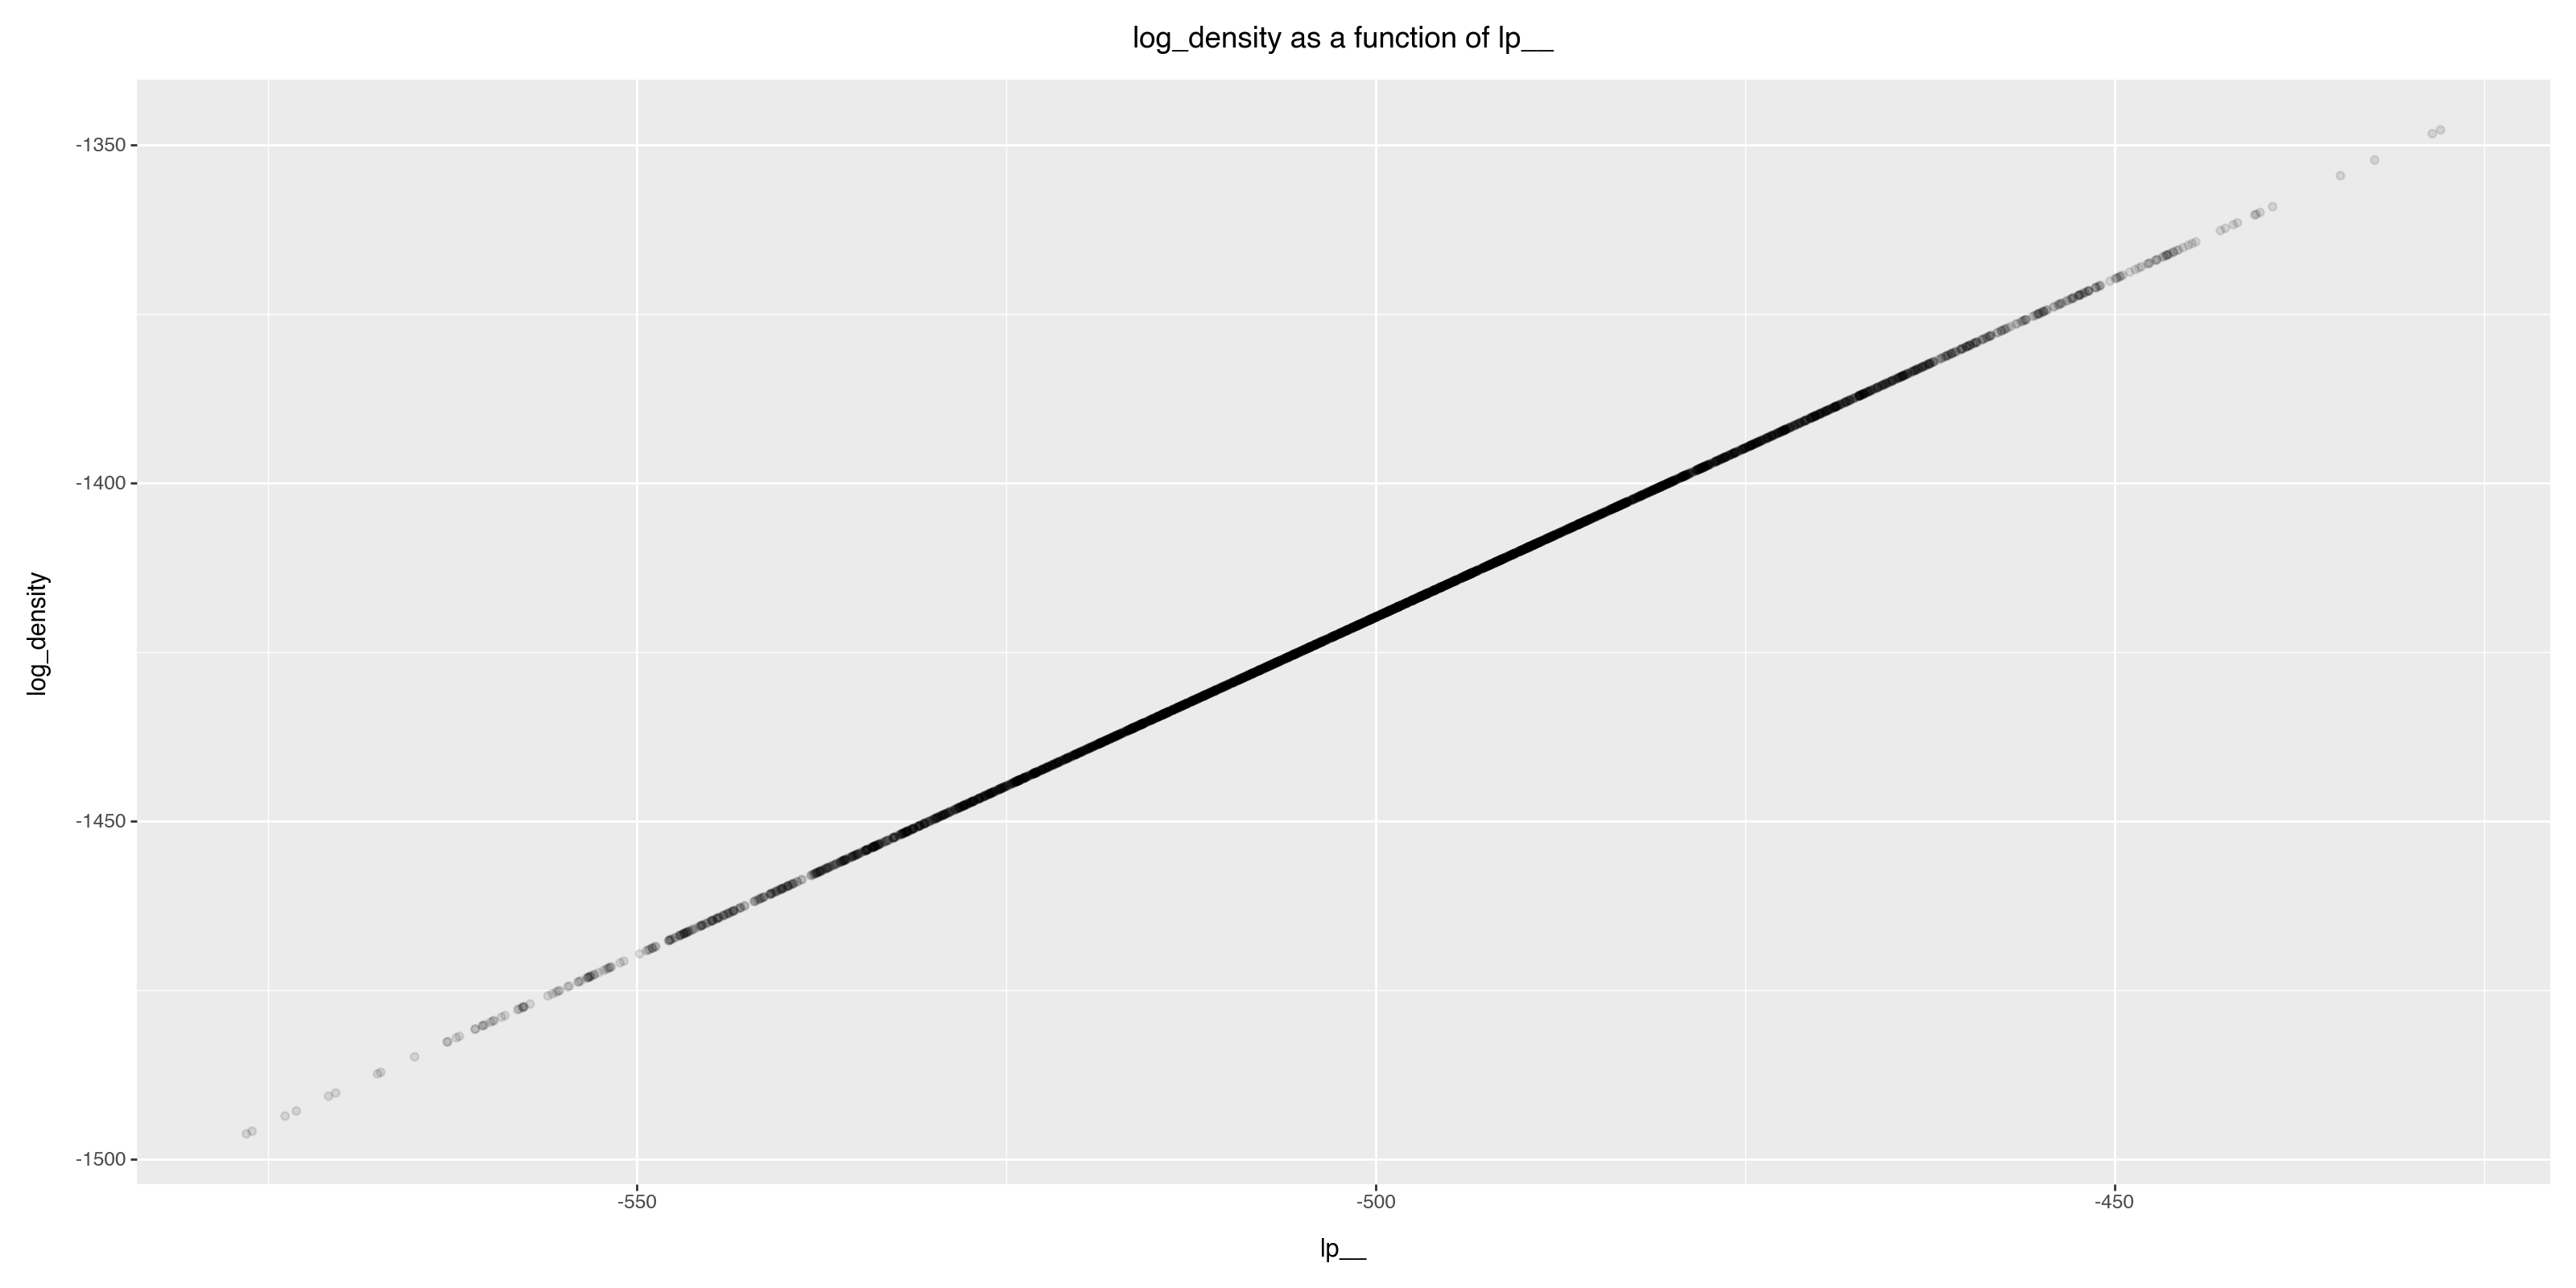

In [10]:
(
    ggplot(
        data=res,
        mapping=aes(x='lp__', y='log_density')
    )
    + geom_point(alpha=0.1)
    + ggtitle("log_density as a function of lp__")
)

In [11]:
log_density_model = LinearRegression()
log_density_model.fit(res[['lp__']], res['log_density'])
(log_density_model.coef_, log_density_model.intercept_)

(array([0.99999974]), -919.8575986716521)

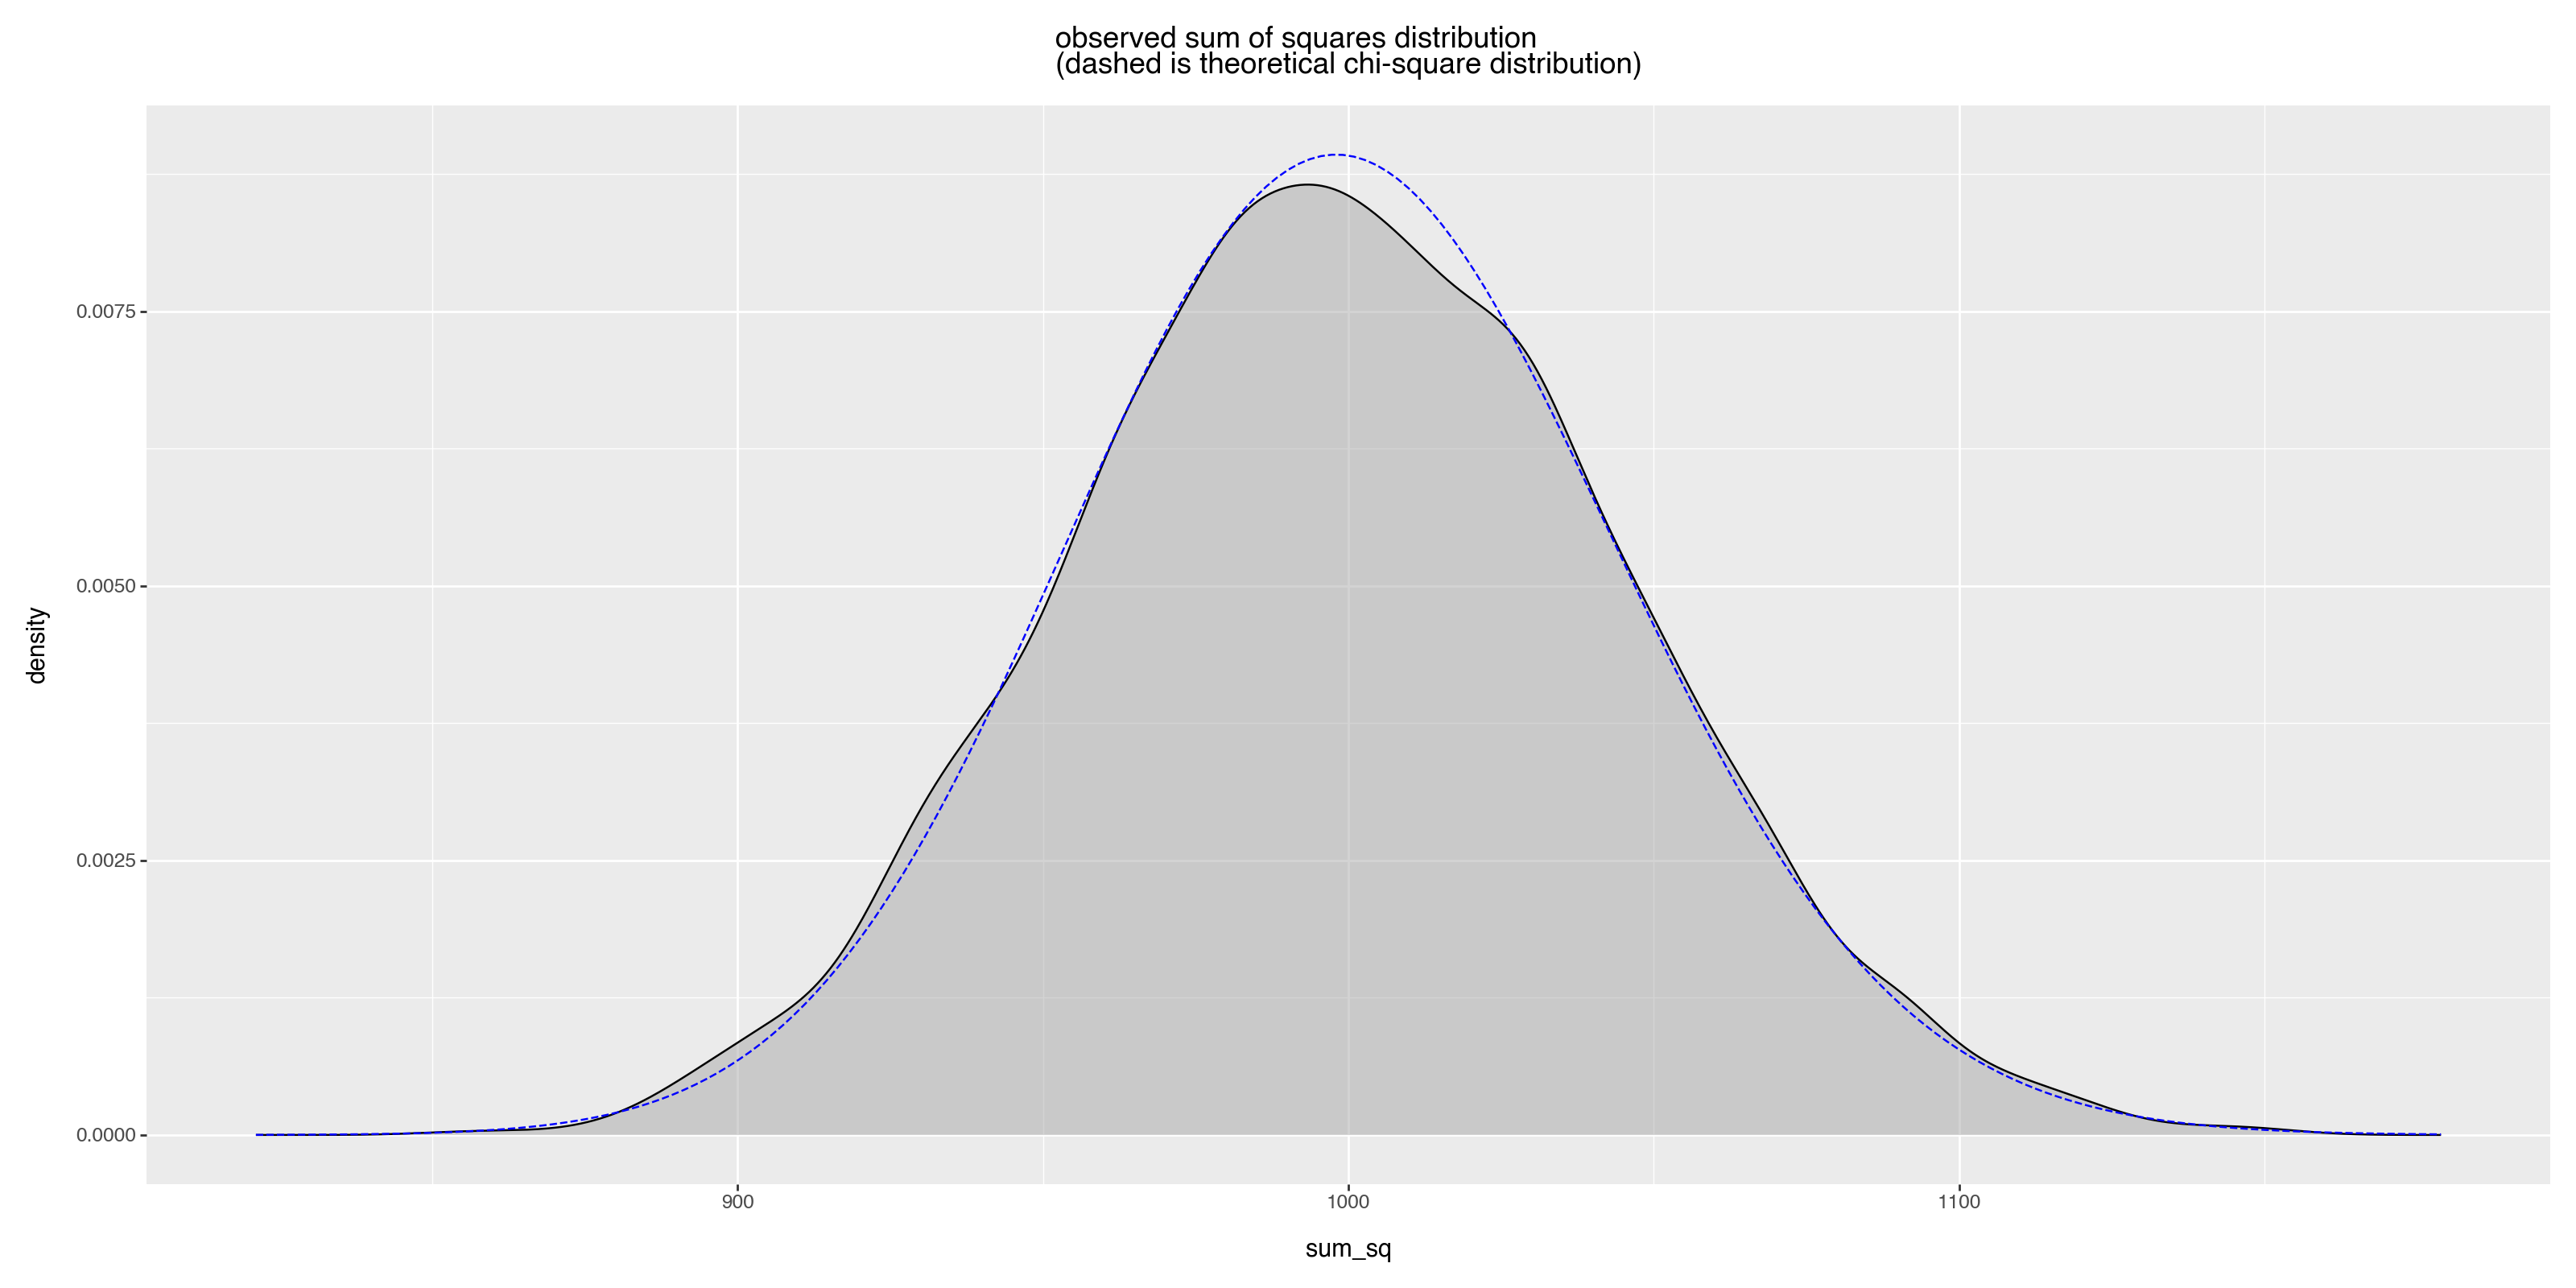

In [12]:
density = pd.DataFrame({
    'sum_sq': np.linspace(
        start=min(N - 4 * np.sqrt(2 * N), np.min(res['sum_sq'])), 
        stop=max(N + 4 * np.sqrt(2 * N), np.max(res['sum_sq'])), 
        num=200),
})
density['pdf'] = chi2.pdf(density['sum_sq'], df=N)
(
    ggplot()
    + geom_density(
        data=res,
        mapping=aes(x='sum_sq'),
        fill='darkgrey', 
        alpha=0.5)
    + geom_line(
        data=density,
        mapping=aes(x='sum_sq', y='pdf'), 
        color='blue', 
        linetype='dashed',
    )
    + ggtitle(
        "observed sum of squares distribution"
        + "\n(dashed is theoretical chi-square distribution)")
)